In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

In [ ]:
# Load dataset (upload Flight_Fare.csv to Colab first)
df = pd.read_csv('Flight_Fare.csv')

In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
df.tail()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


In [ ]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [ ]:
df.isnull().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,1
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,1
Additional_Info,0


In [ ]:
df['Route'] = df['Route'].fillna(df['Route'].mode()[0])
df['Total_Stops'] = df['Total_Stops'].fillna(df['Total_Stops'].mode()[0])

In [ ]:
df.isnull().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,0
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,0
Additional_Info,0


In [ ]:
# Feature engineering
# Convert Date_of_Journey to datetime and extract features
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Journey_Weekday'] = df['Date_of_Journey'].dt.weekday

In [ ]:
# Convert Dep_Time and Arrival_Time to minutes
def convert_to_minutes(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        h, m = map(int, time_str.split(':'))
        return h * 60 + m
    except:
        return np.nan

df['Dep_Minutes'] = df['Dep_Time'].apply(convert_to_minutes)
df['Arrival_Minutes'] = df['Arrival_Time'].apply(lambda x: convert_to_minutes(x.split(' ')[0]))

In [ ]:
# Convert Duration to minutes
def duration_to_minutes(duration):
    if pd.isna(duration):
        return np.nan
    try:
        hours, minutes = 0, 0
        if 'h' in duration:
            hours = int(duration.split('h')[0])
            duration = duration.split('h')[1]
        if 'm' in duration:
            minutes = int(duration.split('m')[0].strip())
        return hours * 60 + minutes
    except:
        return np.nan

df['Duration_Minutes'] = df['Duration'].apply(duration_to_minutes)

In [ ]:
# Encode categorical variables
categorical_columns = ['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info']
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

In [ ]:
# Drop unnecessary columns
df = df.drop(['Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration', 'Route'], axis=1)

In [ ]:
# Handle any remaining null values (e.g., in Duration_Minutes, Dep_Minutes, Arrival_Minutes)
df = df.fillna(df.mean())

In [ ]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Flight Prices')

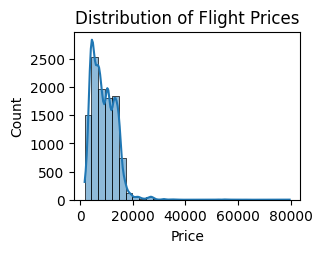

In [ ]:
# 1. Histogram: Price distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Price'], bins=30, kde=True, color='#1f77b4')
plt.title('Distribution of Flight Prices')

<ipython-input-28-652036386>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airline_prices.index, y=airline_prices.values, palette='Set2')


Text(0, 0.5, 'Average Price')

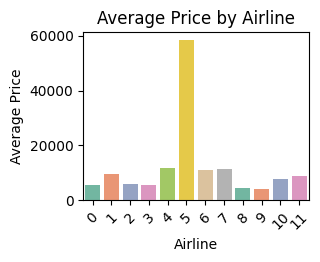

In [ ]:
# 2. Bar Plot: Average price by airline
plt.subplot(2, 2, 2)
airline_prices = df.groupby('Airline')['Price'].mean().sort_values()
sns.barplot(x=airline_prices.index, y=airline_prices.values, palette='Set2')
plt.title('Average Price by Airline')
plt.xticks(rotation=45)
plt.ylabel('Average Price')

Text(0.5, 1.0, 'Distribution of Flights by Total Stops')

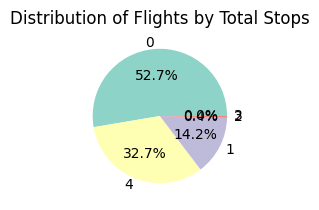

In [ ]:
# 3. Pie Plot: Distribution of flights by total stops
plt.subplot(2, 2, 3)
stops_counts = df['Total_Stops'].value_counts()
plt.pie(stops_counts, labels=stops_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Distribution of Flights by Total Stops')

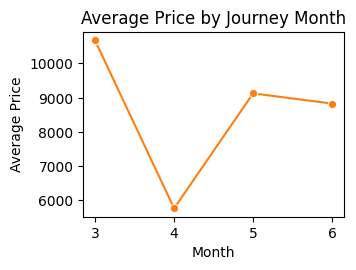

In [ ]:
# 4. Line Chart: Average price by journey month
plt.subplot(2, 2, 4)
month_prices = df.groupby('Journey_Month')['Price'].mean()
sns.lineplot(x=month_prices.index, y=month_prices.values, marker='o', color='#ff7f0e')
plt.title('Average Price by Journey Month')
plt.xlabel('Month')
plt.ylabel('Average Price')

plt.tight_layout()
plt.show()

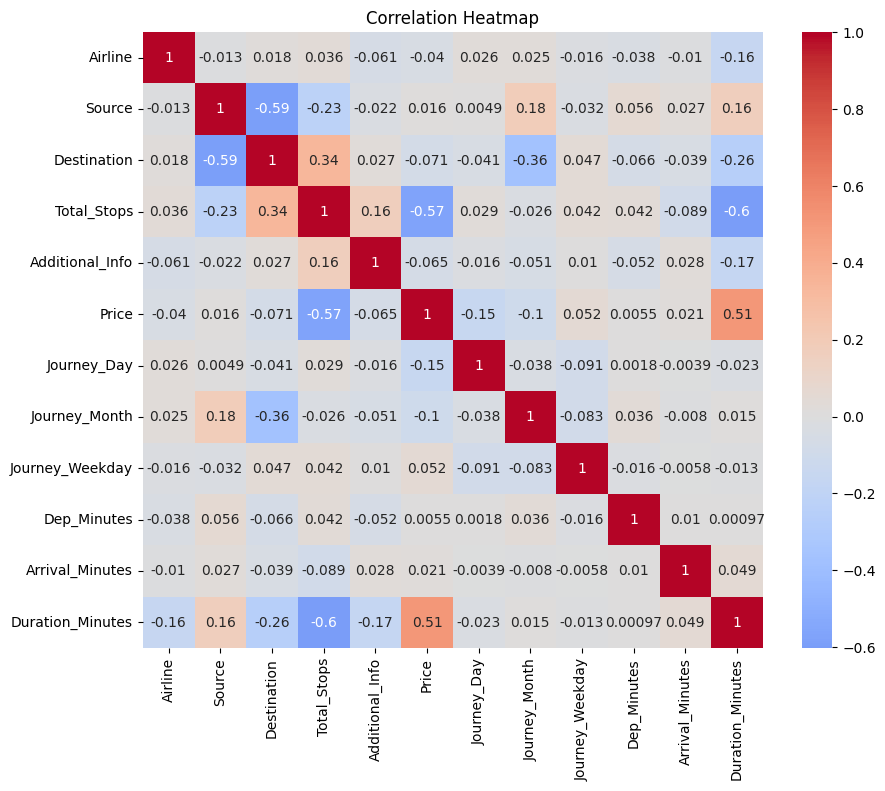

In [ ]:
# 5. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Prepare features and target
X = df.drop('Price', axis=1)
y = df['Price']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"\n{name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")


Linear Regression Results:
MSE: 12193473.32
R2 Score: 0.42

Decision Tree Results:
MSE: 4776871.54
R2 Score: 0.77

Random Forest Results:
MSE: 2761706.73
R2 Score: 0.87

AdaBoost Results:
MSE: 10767872.40
R2 Score: 0.49

XGBoost Results:
MSE: 2787677.75
R2 Score: 0.87


In [ ]:
# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
print("\nBest Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest R2 Score:", rf_grid.best_score_)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest R2 Score: 0.8670536297334135


In [ ]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=5, scoring='r2', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)
print("\nBest XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost R2 Score:", xgb_grid.best_score_)


Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best XGBoost R2 Score: 0.8625761151313782


In [ ]:
# Find best model
best_model = max(results.items(), key=lambda x: x[1]['R2'])
print(f"\nBest Model: {best_model[0]}")
print(f"Best R2 Score: {best_model[1]['R2']:.2f}")
print(f"Best MSE: {best_model[1]['MSE']:.2f}")


Best Model: Random Forest
Best R2 Score: 0.87
Best MSE: 2761706.73


In [ ]:
import pickle

model = RandomForestRegressor().fit(X_train, y_train)

# Save the model to a .pkl file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("✅ Model saved as 'model.pkl'")
